In [1]:
import timeit

import matplotlib.pyplot as plt
from jax import jit, grad, vmap
from jax import numpy as jnp
from jax.scipy.optimize import minimize
from jax import value_and_grad

#import scipy
#from scipy.integrate import solve_ivp
import numpy as np
from jax.scipy.linalg import expm
from scipy.signal import gaussian

from qiskit.quantum_info.operators import Operator
from qiskit_ode import dispatch, solve_lmde, solve_ode
from qiskit_ode.dispatch import Array
from qiskit_ode.models import HamiltonianModel
from qiskit_ode.signals import Signal, DiscreteSignal

###############
# needed these:
from jax.config import config
config.update("jax_enable_x64", True)
dispatch.set_default_backend('jax')
###############

from qiskit_ode_internal.perturbation import solve_lmde_perturbation
from discrete_signals import get_param_to_signal
from objectives import get_grape_fidelity_func

Z = Array([[1., 0.], [0., -1.]], dtype=complex)
X = Array([[0., 1.], [1., 0.]], dtype=complex)
Y = Array([[0., -1j], [1j, 0.]], dtype=complex)

tol = 1e-8

# 1. Approximate fidelity curve with Magnus terms, in the presence of 1 perturbation

Here we set up a duffing oscillator model in the rotating frame of an on-resonance drive frequency, after the RWA:
\begin{equation}
    H(t) = 2\pi\delta a^\dagger a+\pi \alpha a^\dagger a (a^\dagger a - 1) + 2 \pi r[ c_x(t) (a + a^\dagger) + c_y(t) i(a - a^\dagger)],
\end{equation}
where
- $\delta$ is the difference between the qubit frequency and drive frequency
- $\alpha$ is the anharmonicity
- $r$ is the drive strength, and
- $c_x(t)$ and $c_y(t)$ are the x and y control fields

In [2]:
#setting

dim = 2 # dimension cutoff for oscillators

# truncated annihilation, creation, and number operators
a = jnp.diag(np.sqrt(np.arange(1, dim, dtype=complex)), -1)
adag = a.conj().transpose()
numb = jnp.diag(np.arange(dim, dtype=complex))

# truncated oscillator X and Y
osc_X = a + adag
osc_Y = 1j*(a-adag)


# model parameters - work in units of GHz/ns
anharm = -0.33
drive_strength = 0.02

# drift Hamiltonian on resonance
H0 = Array(np.pi * anharm * numb * (numb - jnp.eye(dim)))

# control terms - X and Y multiplied by 2 pi * drive_strength
Hc = Array(2 * np.pi * drive_strength * jnp.array([osc_X, osc_Y]))
perturb = Array(-1j*2*np.pi*numb)

Utarget = X

Alist = -1j * Hc
D = -1j * H0

dt_filter = 0.125
T = 28.125

#get fidelity function
fid_func = get_grape_fidelity_func(X)

## Choose a signal from the 3 cells below
The signals are all in the legendre basis

In [3]:
#use hardcoded signal with good robustness
param = jnp.array([[-4.59237981e+00, 4.24980538e+01, -8.46739534e+01, 5.75898575e+01,-1.50812797e-01],
                  [5.81268528e+02, 1.81435728e+02, -5.81151908e+02, -6.48605967e+01,5.10149009e+02]])

In [4]:
#or, use hardcoded signal, randomly generated
param = jnp.array([[0.42143394, 0.56289994, 0.18579787, 0.46135739, 0.00488543],
                  [0.37749316, 0.87822718, 0.18513398, 0.20995738, 0.47369254]])

In [5]:
#or, randomly generate your own signal
param = jnp.array(np.random.rand(2,5))

In [6]:
#Convert the signal from legendre basis to time series

#get the filter
param_to_signal = get_param_to_signal(4, 25)
#get the signal
signal = param_to_signal(param)
signal1 = signal[:,0]
signal2 = signal[:,1]

pc1 = DiscreteSignal(dt=dt_filter, samples=signal1,carrier_freq=0.)
pc2 = DiscreteSignal(dt=dt_filter, samples=signal2,carrier_freq=0.)
operators = [H0, Hc[0], Hc[1]]
signals = [1., pc1, pc2]
hamiltonian = HamiltonianModel(operators=operators, signals=signals)
#hamiltonian.frame = hamiltonian.drift

def G(t):#the generator
    N_steps = jnp.linspace(0, dt_filter * 225, 225)
    c1 = pc1(t)
    c2 = pc2(t)
    return -1j*(H0 + c1*Hc[0] + c2*Hc[1])

def A0(t):#the perturbation
    return perturb

In [7]:
hamiltonian.drift

Array([[0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

In [8]:
#simulation 
results = solve_lmde_perturbation(A_list=[A0], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=5,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator=G, # generator
                             y0=np.eye(2), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=tol, # standard solver arguments
                             atol=tol)

In [9]:
"""
#use the "hamiltonian" as input. Equivalent to using the "generator"
results = solve_lmde_perturbation(A_list=[A0], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=5,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator = hamiltonian,
                             y0=np.eye(2), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=tol, # standard solver arguments
                             atol=tol)
"""

'\n#use the "hamiltonian" as input. Equivalent to using the "generator"\nresults = solve_lmde_perturbation(A_list=[A0], # list of A matrices\n                             perturbation_method=\'symmetric_magnus\',\n                             perturbation_order=5,\n                             t_span=[0, T], # integrate over one period of drive oscillation\n                             generator = hamiltonian,\n                             y0=np.eye(2), # initial state for base DE U\'(t) = G(t)U(t)\n                             method=\'jax_odeint\',\n                             rtol=tol, # standard solver arguments\n                             atol=tol)\n'

In [10]:
U = results.y[-1] #the unitary tranformation when there's no perturbation
#symmetric Magnus terms from 1st to 5th order
M1 = results.perturbation_results[[0]][-1]
M2 = results.perturbation_results[[0, 0]][-1]
M3 = results.perturbation_results[[0, 0, 0]][-1]
M4 = results.perturbation_results[[0, 0, 0, 0]][-1]
M5 = results.perturbation_results[[0, 0, 0, 0, 0]][-1]

In [11]:
#compute the estimated unitary transformation in the presence of perturbation, using the Magnus terms
#detuning: magnitude of perturbation
#order: order of approximation
def err_est(detuning, order):
    if order == 1:       
        U_approx = U@expm(detuning*M1)  # 1st order
    elif order == 2:
        U_approx = U@expm(detuning*M1+detuning**2*M2)  # 2nd order
    elif order == 3:
        U_approx = U@expm(detuning*M1+detuning**2*M2+detuning**3*M3) #3rd order
    elif order == 4:
        U_approx = U@expm(detuning*M1+detuning**2*M2+detuning**3*M3+detuning**4*M4) #4th order
    elif order == 5:
        U_approx = U@expm(detuning*M1+detuning**2*M2+detuning**3*M3+detuning**4*M4+detuning**5*M5) #5th order
    fid = fid_func(U_approx)
    return 1. - fid 

In [12]:
#range of delta values that we consider
z_vals = jnp.linspace(-1.5*drive_strength, 1.5*drive_strength, 20)

#obtain the errors estimated using the Magnus terms
err_estimate1 = [err_est(z,1) for z in z_vals]
err_estimate2 = [err_est(z,2) for z in z_vals]
err_estimate3 = [err_est(z,3) for z in z_vals]
err_estimate4 = [err_est(z,4) for z in z_vals]
err_estimate5 = [err_est(z,5) for z in z_vals]

In [13]:
#exact error with the perturbation
operators1 = [H0, Hc[0], Hc[1], 1j*perturb]
hamiltonian1 = HamiltonianModel(operators=Array(operators1))
def exact_fid(detuning):
    signals1 = [1., pc1, pc2, Array(detuning)]
    ham_copy = hamiltonian1.copy()
    ham_copy.signals = signals1
    time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(2), atol=tol, rtol=tol,method='jax_odeint')
    return fid_func(time_results.y[-1]).data

fid_exact = vmap(exact_fid)(z_vals)

Text(0, 0.5, 'Error')

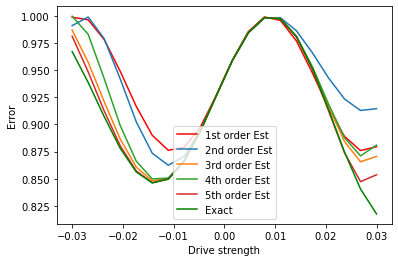

In [14]:
#plot the estimate and the exact errors together
plt.plot(z_vals, err_estimate1,color='r',label='1st order Est')
plt.plot(z_vals, err_estimate2,label='2nd order Est')
plt.plot(z_vals, err_estimate3,label='3rd order Est')
plt.plot(z_vals, err_estimate4,label='4th order Est')
plt.plot(z_vals, err_estimate5,label='5th order Est')
plt.plot(z_vals, 1-fid_exact,color='g',label='Exact')
plt.legend()
plt.xlabel('Drive strength')
plt.ylabel('Error')

## Compare the costs: use an approximate fid curve v.s. the exact fid curve in objective function

In [15]:
#random inputs
inputs = jnp.array(np.random.rand(10,2,5))

#objective function defined with the approximate fid curve (2nd order)
def obj1(param1):
    sig1 = param_to_signal(param1)
    pc1 = DiscreteSignal(dt=dt_filter, samples=sig1[:,0],carrier_freq=0.)
    pc2 = DiscreteSignal(dt=dt_filter, samples=sig1[:,1],carrier_freq=0.)
    sigs = [1., pc1, pc2]
    ham = HamiltonianModel(operators=operators, signals=sigs,validate=False)
    ham.frame = ham.drift
    results = solve_lmde_perturbation(A_list=[A0], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=2,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator = ham,
                             y0=np.eye(2), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=tol, # standard solver arguments
                             atol=tol)
    U = results.y[-1]
    M1 = results.perturbation_results[[0]][-1]
    M2 = results.perturbation_results[[0, 0]][-1]
    def err(detuning):
        U_approx = U@expm(detuning*M1+detuning**2*M2)
        fid = Array(fid_func(U_approx)).data
        return 1. - fid
    err_estimate = vmap(err)(z_vals)
    n_samples = len(err_estimate)
    filter_Gaussian = jnp.array(gaussian(n_samples, n_samples/5))/n_samples
    return Array(jnp.sum(err_estimate*filter_Gaussian)).data

#objective function defined with the exact fid curve
def obj2(param2):
    sig2 = param_to_signal(param2)
    pc1 = DiscreteSignal(dt=dt_filter, samples=sig2[:,0],carrier_freq=0.)
    pc2 = DiscreteSignal(dt=dt_filter, samples=sig2[:,1],carrier_freq=0.)
    
    def err(detuning):
        signals_detuning = [1., pc1, pc2, Array(detuning)]
        ham_copy = hamiltonian1.copy()
        ham_copy.signals = signals_detuning
        time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(2), atol=tol, rtol=tol,method='jax_odeint')
        return 1 - Array(fid_func(time_results.y[-1])).data

    err_exact = vmap(err)(z_vals)
    n_samples = len(err_exact)
    filter_Gaussian = jnp.array(gaussian(n_samples, n_samples/5))/n_samples
    return Array(jnp.sum(err_exact*filter_Gaussian)).data

def f1():
    jit_obj = jit(value_and_grad(obj1))
    for i in range(len(inputs)):
        val, grad = jit_obj(inputs[i])

def f2():
    jit_obj = jit(value_and_grad(obj2))
    for i in range(len(inputs)):
        val, grad = jit_obj(inputs[i])

In [16]:
from time import time

In [17]:
#time it takes to evaluate the approximation

jit_obj = jit(value_and_grad(obj1))

start = time()
val = jit_obj(inputs[0])[0].block_until_ready()
jit_time = time() - start

jitted_times = []
for rand_in in inputs[1:]:
    start = time()
    val = jit_obj(rand_in)[0].block_until_ready()
    jitted_times.append(time() - start)

print('Time to jit and run once: ' + str(jit_time))
print('Average jitted run time: ' + str(np.sum(jitted_times) / len(jitted_times)))
print('Average time including initial jit: ' + str((np.sum(jitted_times) + jit_time) / (len(jitted_times) + 1)))

Time to jit and run once: 15.077179908752441
Average jitted run time: 0.6432187027401395
Average time including initial jit: 2.0866148233413697


In [18]:
#time it takes to evaluate the exact fid curve

jit_obj = jit(value_and_grad(obj2))

start = time()
val = jit_obj(inputs[0])[0].block_until_ready()
jit_time = time() - start

jitted_times = []
for rand_in in inputs[1:]:
    start = time()
    val = jit_obj(rand_in)[0].block_until_ready()
    jitted_times.append(time() - start)

print('Time to jit and run once: ' + str(jit_time))
print('Average jitted run time: ' + str(np.sum(jitted_times) / len(jitted_times)))
print('Average time including initial jit: ' + str((np.sum(jitted_times) + jit_time) / (len(jitted_times) + 1)))

Time to jit and run once: 10.370642185211182
Average jitted run time: 5.526943657133314
Average time including initial jit: 6.011313509941101


In [19]:
jit_obj = jit_obj2 = jit(value_and_grad(obj1))

In [20]:
%time test = jit_obj(inputs[1])[0].block_until_ready()

CPU times: user 14.5 s, sys: 87.6 ms, total: 14.6 s
Wall time: 14.6 s


In [21]:
jit_obj2 = jit(value_and_grad(obj2))

In [22]:
%time test = jit_obj2(inputs[1])[0].block_until_ready()

CPU times: user 14.1 s, sys: 264 ms, total: 14.4 s
Wall time: 13.6 s


# 2. Approximate fidelity with Magnus terms, in the presence of 2 perturbations

We now have 2 perturbations, $\delta_0$ and $\delta_1$, where $\delta_1$ is similar to a variation in transfer function.
\begin{equation}
    H(t) = 2\pi\delta_0 a^\dagger a+\pi \alpha a^\dagger a (a^\dagger a - 1) + 2 \pi r(1+\delta_1)[ c_x(t) (a + a^\dagger) + c_y(t) i(a - a^\dagger)].
\end{equation}

In [23]:
# the added perturbation - transfer function variation
def A1(t):
    N_steps = jnp.linspace(0, dt_filter * 225, 225)
    c1 = pc1(t)
    c2 = pc2(t)
    return -1j*(c1*Hc[0] + c2*Hc[1])

#use the "generator" as input
results = solve_lmde_perturbation(A_list=[A0, A1], # list of A matrices
                             perturbation_method='symmetric_magnus',
                             perturbation_order=5,
                             t_span=[0, T], # integrate over one period of drive oscillation
                             generator=G, # generator
                             y0=np.eye(2), # initial state for base DE U'(t) = G(t)U(t)
                             method='jax_odeint',
                             rtol=1e-13, # standard solver arguments
                             atol=1e-13)

In [24]:
U = results.y[-1] #unitary tranformation when there's no error
#symmetric Magnus terms
M0 = results.perturbation_results[[0]][-1]
M1 = results.perturbation_results[[1]][-1]
M00 = results.perturbation_results[[0, 0]][-1]
M11 = results.perturbation_results[[1, 1]][-1]
M01 = results.perturbation_results[[0, 1]][-1]
M000 = results.perturbation_results[[0, 0, 0]][-1]
M001 = results.perturbation_results[[0, 0, 1]][-1]
M011 = results.perturbation_results[[0, 1, 1]][-1]
M111 = results.perturbation_results[[1, 1, 1]][-1]
M0000 = results.perturbation_results[[0, 0, 0, 0]][-1]
M0001 = results.perturbation_results[[0, 0, 0, 1]][-1]
M0011 = results.perturbation_results[[0, 0, 1, 1]][-1]
M0111 = results.perturbation_results[[0, 1, 1, 1]][-1]
M1111 = results.perturbation_results[[1, 1, 1, 1]][-1]
M00000 = results.perturbation_results[[0, 0, 0, 0, 0]][-1]
M00001 = results.perturbation_results[[0, 0, 0, 0, 1]][-1]
M00011 = results.perturbation_results[[0, 0, 0, 1, 1]][-1]
M00111 = results.perturbation_results[[0, 0, 1, 1, 1]][-1]
M01111 = results.perturbation_results[[0, 1, 1, 1, 1]][-1]
M11111 = results.perturbation_results[[1, 1, 1, 1, 1]][-1]

In [25]:
# get the 2nd and 3rd order approximate error rates using the Magnus terms
def err_est(c1, c2, order):
    #2nd order approximation
    if order == 2:
        U_approx = U@expm(c1*M0+c2*M1+c1*c2*M01+c1**2*M00+c2**2*M11)
    #3rd order approximation
    elif order == 3:
        U_approx = U@expm(c1*M0+c2*M1+c1*c2*M01+c1**2*M00+c2**2*M11
                          +c1**3*M000+c2**3*M111+c1**2*c2*M001+c1*c2**2*M011)
    elif order == 4:
        c11 = c1 * c1
        c12 = c1 * c2
        c22 = c2 * c2
        c111 = c1 * c11
        c112 = c1 * c12
        c122 = c1 * c22
        c222 = c2 * c22
        c1111 = c1 * c111
        c1112 = c1 * c112
        c1122 = c1 * c122
        c1222 = c1 * c222
        c2222 = c2 * c222
        U_approx = U@expm(c1*M0 + c2*M1 
                          + c12*M01 + c11*M00 + c22*M11
                          +c111*M000+c222*M111+c112*M001+c122*M011
                          + c1111 * M0000 + c1112 * M0001 + c1122 * M0011 + c1222 * M0111 + c2222 * M1111)
    
    elif order == 5:
        c11 = c1 * c1
        c12 = c1 * c2
        c22 = c2 * c2
        c111 = c1 * c11
        c112 = c1 * c12
        c122 = c1 * c22
        c222 = c2 * c22
        c1111 = c1 * c111
        c1112 = c1 * c112
        c1122 = c1 * c122
        c1222 = c1 * c222
        c2222 = c2 * c222
        c11111 = c1 * c1111
        c11112 = c1 * c1112
        c11122 = c1 * c1122
        c11222 = c1 * c1222
        c12222 = c1 * c2222
        c22222 = c2 * c2222
        U_approx = U@expm(c1*M0 + c2*M1 
                          + c12*M01 + c11*M00 + c22*M11
                          +c111*M000+c222*M111+c112*M001+c122*M011
                          + c1111 * M0000 + c1112 * M0001 + c1122 * M0011 + c1222 * M0111 + c2222 * M1111
                         + c11111 * M00000 + c11112 * M00001 + c11122 * M00011 + c11222 * M00111 + c12222 * M01111 + c22222 * M11111)
        
    fid = fid_func(U_approx)
    return 1. - fid 

v_vals = jnp.linspace(-0.2, 0.2, len(z_vals))
err_estimate2 = [err_est(z,v,2) for v in v_vals for z in z_vals]
err_estimate3 = [err_est(z,v,3) for v in v_vals for z in z_vals]
err_estimate4 = [err_est(z,v,4) for v in v_vals for z in z_vals]
err_estimate5 = [err_est(z,v,5) for v in v_vals for z in z_vals]

In [26]:
#exact error with the two perturbations
def exact_err(args):
    c1,c2 = args
    pc1_ = DiscreteSignal(dt=dt_filter, samples=(1+c2)*signal1,carrier_freq=0.)
    pc2_ = DiscreteSignal(dt=dt_filter, samples=(1+c2)*signal2,carrier_freq=0.)
    signals2 = [1., pc1_, pc2_, Array(c1)]
    ham_copy = hamiltonian1.copy()
    ham_copy.signals = signals2
    time_results = solve_lmde(ham_copy, t_span=[0,T], y0=np.eye(2), atol=tol, rtol=tol,method='jax_odeint')
    return 1.-fid_func(time_results.y[-1]).data

err_exact = vmap(exact_err)((jnp.tile(z_vals,len(v_vals)),jnp.repeat(v_vals,len(z_vals))))

<ipython-input-27-8d6ba51232a3>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax0.pcolormesh(z_vals, v_vals, err_exact.reshape(len(z_vals),len(v_vals)))
<ipython-input-27-8d6ba51232a3>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolormesh(z_vals, v_vals, jnp.array(err_estimate2).reshape(len(z_vals),len(v_vals)))
<ipython-input-27-8d6ba51232a3>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C 

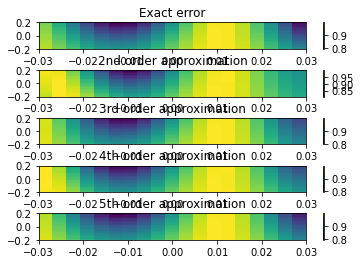

In [27]:
#plot the estimates and the exact errors together
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5)
im0 = ax0.pcolormesh(z_vals, v_vals, err_exact.reshape(len(z_vals),len(v_vals)))
im1 = ax1.pcolormesh(z_vals, v_vals, jnp.array(err_estimate2).reshape(len(z_vals),len(v_vals)))
im2 = ax2.pcolormesh(z_vals, v_vals, jnp.array(err_estimate3).reshape(len(z_vals),len(v_vals)))
im3 = ax3.pcolormesh(z_vals, v_vals, jnp.array(err_estimate4).reshape(len(z_vals),len(v_vals)))
im4 = ax4.pcolormesh(z_vals, v_vals, jnp.array(err_estimate5).reshape(len(z_vals),len(v_vals)))
ax0.title.set_text('Exact error')
ax1.title.set_text('2nd order approximation')
ax2.title.set_text('3rd order approximation')
ax3.title.set_text('4th order approximation')
ax4.title.set_text('5th order approximation')
fig.colorbar(im0, ax=ax0)
fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
fig.colorbar(im4, ax=ax4)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.8)
plt.show()

Text(0, 0.5, 'Error')

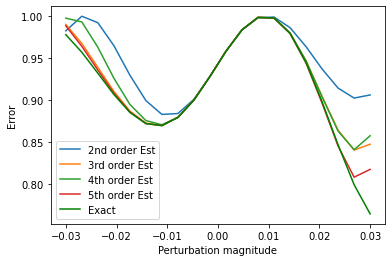

In [28]:
#Plot the diagonal of the 2D plot above
dia_err_exact = [err_exact.reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err2 = [jnp.array(err_estimate2).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err3 = [jnp.array(err_estimate3).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err4 = [jnp.array(err_estimate4).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]
dia_err5 = [jnp.array(err_estimate5).reshape(len(z_vals),len(v_vals))[i,i] for i in range(len(z_vals))]

plt.plot(z_vals, dia_err2,label='2nd order Est')
plt.plot(z_vals, dia_err3,label='3rd order Est')
plt.plot(z_vals, dia_err4,label='4th order Est')
plt.plot(z_vals, dia_err5,label='5th order Est')
plt.plot(z_vals, dia_err_exact,color='g',label='Exact')
plt.legend()
plt.xlabel('Perturbation magnitude')
plt.ylabel('Error')